In [1]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings(action='ignore')
import pickle
import time
from sklearn.ensemble import GradientBoostingClassifier 
from scipy.stats import randint
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from bayes_opt import BayesianOptimization
from xgboost import XGBClassifier # model 
from xgboost import plot_importance
from sklearn.ensemble import VotingClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [246]:
import sys   
!{sys.executable} -m pip install time

ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time


In [2]:
def seed_everything(seed):
    random.seed(seed) #파이썬 자체 모듈 random 모듈의 시드 고정
    os.environ['PYTHONHASHSEED'] = str(seed) 
    np.random.seed(seed) #넘파이를 사용할 경우
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
    
seed_everything(37) # Seed 고정

# Data Load

In [7]:
#데이터프레임 불러오기
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [90]:
sub = pd.read_csv('./sample_submission.csv')

In [10]:
train_df['LINE'].unique()

array(['T050304', 'T050307', 'T010306', 'T010305', 'T100304', 'T100306'],
      dtype=object)

In [8]:
train_df #O_31은 모든 게 다 측정된다?

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,TRAIN_593,1,0.526546,2022-09-08 14:30,T100306,T_31,2.0,95.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,TRAIN_594,0,0.524022,2022-09-08 22:38,T050304,A_31,NaN,NaN,NaN,NaN,...,49.47,53.07,50.89,55.10,66.49,1.0,NaN,NaN,NaN,NaN
595,TRAIN_595,0,0.521289,2022-09-08 22:47,T050304,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
596,TRAIN_596,1,0.531375,2022-09-08 14:38,T100304,O_31,40.0,94.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
train_df.iloc[:20,:16] #그렇지만 A_31은 X_1부터 X_10까지 다 측정된다.

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,TRAIN_005,2,0.537833,2022-06-13 5:55,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,TRAIN_006,1,0.533665,2022-06-13 6:03,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,TRAIN_007,2,0.540003,2022-06-13 6:11,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,TRAIN_008,1,0.531821,2022-06-13 6:19,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,TRAIN_009,2,0.538049,2022-06-13 6:28,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
test_df[test_df['PRODUCT_CODE']== 'O_31']

,PRODUCT_ID,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
138,TEST_138,2022-10-19 14:17,T100304,O_31,4.0,98.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
256,TEST_256,2022-10-31 14:17,T100304,O_31,154.0,97.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
257,TEST_257,2022-10-31 14:25,T100306,O_31,146.0,94.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
287,TEST_287,2022-11-03 20:34,T100304,O_31,133.0,100.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
submission.head()

,PRODUCT_ID,Y_Class
0,TEST_000,0
1,TEST_001,0
2,TEST_002,0
3,TEST_003,0
4,TEST_004,0


위 세 가지 데이터 프레임을 보고 우리가 무엇을 예측해야하는지 알 수 있다.

# EDA 데이터 분석

In [4]:
hier = train_df[train_df['X_1'].isnull()].groupby(['PRODUCT_CODE', 'LINE'])['X_1'].count()
hier

PRODUCT_CODE  LINE   
A_31          T010305    0
              T010306    0
              T050304    0
              T050307    0
Name: X_1, dtype: int64

In [5]:
train_df[train_df['PRODUCT_CODE']== 'O_31']

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
569,TRAIN_569,1,0.530533,2022-09-03 18:32,T100304,O_31,4.0,98.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
570,TRAIN_570,2,0.534951,2022-09-03 18:40,T100306,O_31,6.0,90.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
571,TRAIN_571,1,0.525916,2022-09-03 18:48,T100304,O_31,4.0,100.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
572,TRAIN_572,2,0.535205,2022-09-03 18:56,T100306,O_31,6.0,89.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
596,TRAIN_596,1,0.531375,2022-09-08 14:38,T100304,O_31,40.0,94.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
597,TRAIN_597,1,0.533702,2022-09-08 14:46,T100306,O_31,21.0,87.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


['T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305']

In [108]:
train_df_pl = train_df[(train_df['PRODUCT_CODE']=='A_31') & (train_df['LINE']=='T010305')]
#train_df_pl = train_df[train_df['PRODUCT_CODE']=='A_31']
train_df_pl.iloc[:,986:1006]

,X_981,X_982,X_983,X_984,X_985,X_986,X_987,X_988,X_989,X_990,X_991,X_992,X_993,X_994,X_995,X_996,X_997,X_998,X_999,X_1000
28,24.6,24.441935,24.3,74.5,74.383871,74.3,1.0,1.0,1.0,NaN,NaN,0.0,1507.0,1507.000000,1507.0,180076.0,180054.25810,180034.0,541.0,541.0
33,24.3,24.254839,24.2,73.4,73.303226,73.2,1.0,1.0,1.0,NaN,NaN,0.0,323.0,322.516129,322.0,37342.0,37322.58065,37302.0,107.0,107.0
39,24.5,24.341935,24.2,74.0,73.967742,73.9,1.0,1.0,1.0,NaN,NaN,0.0,258.0,257.935484,257.0,30363.0,30341.58065,30322.0,92.0,92.0
40,25.1,24.964516,24.8,73.3,73.196774,73.1,1.0,1.0,1.0,NaN,NaN,0.0,924.0,924.000000,924.0,115928.0,115908.70970,115888.0,331.0,331.0
41,25.2,25.006452,24.8,73.2,73.129032,73.1,1.0,1.0,1.0,NaN,NaN,0.0,938.0,937.354839,937.0,117438.0,117416.58060,117397.0,336.0,336.0
48,24.3,24.148387,24.0,74.3,74.267742,74.2,1.0,1.0,1.0,NaN,NaN,0.0,1036.0,1036.000000,1036.0,124324.0,124303.93550,124283.0,402.0,402.0
52,24.3,24.232258,24.1,74.6,74.506452,74.5,1.0,1.0,1.0,NaN,NaN,0.0,240.0,240.000000,240.0,29062.0,29042.41935,29021.0,91.0,91.0
57,24.6,24.441935,24.2,74.6,74.512903,74.5,1.0,1.0,1.0,NaN,NaN,0.0,1538.0,1538.000000,1538.0,196685.0,196663.83870,196644.0,555.0,555.0
58,24.5,24.290625,24.2,74.1,73.993750,73.9,1.0,1.0,1.0,NaN,NaN,0.0,1566.0,1566.000000,1566.0,200477.0,200454.40630,200432.0,565.0,565.0
59,24.5,24.334375,24.1,75.0,74.887500,74.8,1.0,1.0,1.0,NaN,NaN,0.0,1624.0,1623.812500,1623.0,207968.0,207947.50000,207927.0,586.0,586.0


In [113]:
train_df_pl = train_df[(train_df['PRODUCT_CODE']=='A_31') & (train_df['LINE']=='T010306')] #70row
train_df_pl.iloc[:,336:356] 

,X_331,X_332,X_333,X_334,X_335,X_336,X_337,X_338,X_339,X_340,X_341,X_342,X_343,X_344,X_345,X_346,X_347,X_348,X_349,X_350
27,128.0,128.0,127.0,130.0,36.0,999.0,NaN,NaN,NaN,0.22,0.23,0.22,2.0,0.00061,0.00095,0.00049,18.0,0.000084,0.000100,0.000062
31,127.0,128.0,127.0,130.0,37.0,999.0,NaN,NaN,NaN,0.22,0.23,0.22,2.0,0.00086,0.00140,0.00081,18.0,0.000086,0.000098,0.000061
32,128.0,128.0,127.0,130.0,35.0,999.0,NaN,NaN,NaN,0.22,0.23,0.22,2.0,0.00077,0.00130,0.00072,18.0,0.000088,0.000100,0.000064
38,128.0,128.0,127.0,130.0,36.0,999.0,NaN,NaN,NaN,0.22,0.22,0.22,2.0,0.00083,0.00091,0.00081,18.0,0.000093,0.000110,0.000068
47,127.0,128.0,127.0,130.0,36.0,999.0,NaN,NaN,NaN,0.22,0.23,0.22,2.0,0.00083,0.00110,0.00078,18.0,0.000089,0.000100,0.000067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,128.0,128.0,127.0,130.0,36.0,999.0,NaN,NaN,NaN,0.22,0.23,0.22,2.0,0.00079,0.00120,0.00074,18.0,0.000088,0.000097,0.000068
501,128.0,128.0,128.0,130.0,36.0,999.0,NaN,NaN,NaN,0.22,0.23,0.22,2.0,0.00078,0.00130,0.00071,18.0,0.000095,0.000110,0.000065
523,128.0,128.0,127.0,130.0,36.0,999.0,NaN,NaN,NaN,0.22,0.23,0.22,2.0,0.00076,0.00130,0.00051,18.0,0.000094,0.000110,0.000065
531,128.0,128.0,127.0,130.0,35.0,999.0,NaN,NaN,NaN,0.22,0.23,0.22,2.0,0.00081,0.00140,0.00076,18.0,0.000089,0.000099,0.000067


In [51]:
train_df_pl = train_df[(train_df['PRODUCT_CODE']=='A_31') & (train_df['LINE']=='T050304')] #78rows
train_df_pl.iloc[:,246:266] 

,X_241,X_242,X_243,X_244,X_245,X_246,X_247,X_248,X_249,X_250,X_251,X_252,X_253,X_254,X_255,X_256,X_257,X_258,X_259,X_260
0,999.0,35.0,35.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,999.0,35.0,35.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,999.0,35.0,35.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,999.0,35.0,35.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,999.0,35.0,35.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,999.0,35.3,35.3,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
582,999.0,35.3,35.3,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
583,999.0,35.3,35.3,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,999.0,35.7,35.7,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
train_df_pl = train_df[(train_df['PRODUCT_CODE']=='A_31') & (train_df['LINE']=='T050307')]
train_df_pl.iloc[:,246:266] 

,X_241,X_242,X_243,X_244,X_245,X_246,X_247,X_248,X_249,X_250,X_251,X_252,X_253,X_254,X_255,X_256,X_257,X_258,X_259,X_260
1,999.0,36.0,36.0,3.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,999.0,36.0,36.0,3.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,999.0,36.0,36.0,3.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,999.0,36.0,36.0,3.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,999.0,36.0,36.0,3.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,999.0,36.0,36.0,3.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,999.0,36.0,36.0,3.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,999.0,36.0,36.0,3.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,999.0,36.0,36.0,3.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,999.0,36.0,36.0,3.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


['T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305']

In [174]:
train_df_pl = train_df[(train_df['PRODUCT_CODE']=='T_31') & (train_df['LINE']=='T100304')]
train_df_pl.iloc[0:100, 90:110]

,X_85,X_86,X_87,X_88,X_89,X_90,X_91,X_92,X_93,X_94,X_95,X_96,X_97,X_98,X_99,X_100,X_101,X_102,X_103,X_104
22,0.0,130.0,130.0,130.0,130.0,37.0,999.0,28.0,NaN,NaN,NaN,2.0,0.0013,0.0013,0.0012,18.0,0.000043,0.000057,0.000030,NaN
23,0.0,130.0,130.0,130.0,130.0,37.0,999.0,28.0,NaN,NaN,NaN,2.0,0.0013,0.0013,0.0012,18.0,0.000042,0.000053,0.000027,NaN
25,0.0,130.0,130.0,130.0,130.0,37.0,999.0,28.0,NaN,NaN,NaN,2.0,0.0013,0.0014,0.0013,18.0,0.000037,0.000047,0.000028,NaN
29,0.0,130.0,130.0,130.0,130.0,37.0,999.0,28.0,NaN,NaN,NaN,2.0,0.0013,0.0014,0.0012,18.0,0.000045,0.000074,0.000029,NaN
37,0.0,130.0,130.0,130.0,130.0,37.0,999.0,28.0,NaN,NaN,NaN,2.0,0.0013,0.0013,0.0013,18.0,0.000037,0.000047,0.000027,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,0.0,130.0,130.0,130.0,130.0,36.0,999.0,28.0,NaN,NaN,NaN,2.0,0.0013,0.0013,0.0012,18.0,0.000038,0.000053,0.000022,NaN
372,0.0,130.0,130.0,130.0,130.0,36.0,999.0,28.0,NaN,NaN,NaN,2.0,0.0013,0.0013,0.0012,18.0,0.000034,0.000058,0.000021,NaN
377,0.0,130.0,130.0,130.0,130.0,36.0,999.0,28.0,NaN,NaN,NaN,2.0,0.0013,0.0013,0.0012,18.0,0.000033,0.000050,0.000022,NaN
378,0.0,130.0,130.0,130.0,130.0,36.0,999.0,28.0,NaN,NaN,NaN,2.0,0.0013,0.0013,0.0012,18.0,0.000033,0.000043,0.000021,NaN


In [163]:
train_df_pl = train_df[(train_df['PRODUCT_CODE']=='T_31') & (train_df['LINE']=='T100306')]
train_df_pl.iloc[:100,106:126]

,X_101,X_102,X_103,X_104,X_105,X_106,X_107,X_108,X_109,X_110,X_111,X_112,X_113,X_114,X_115,X_116,X_117,X_118,X_119,X_120
26,0.000063,0.000072,0.000044,28.0,0.000013,0.000015,0.000004,32.0,0.000004,0.000004,0.000003,40.0,NaN,NaN,NaN,44.0,0.000037,0.000038,0.000032,34.4
30,0.000069,0.000082,0.000044,28.0,0.000012,0.000014,0.000004,32.0,0.000003,0.000005,0.000003,40.0,NaN,NaN,NaN,44.0,0.000036,0.000040,0.000035,34.4
36,0.000061,0.000070,0.000042,28.0,0.000011,0.000014,0.000004,32.0,0.000004,0.000004,0.000003,40.0,NaN,NaN,NaN,44.0,0.000037,0.000039,0.000034,34.3
42,0.000063,0.000071,0.000043,28.0,0.000010,0.000012,0.000005,32.0,0.000003,0.000005,0.000003,40.0,NaN,NaN,NaN,44.0,0.000036,0.000037,0.000032,34.3
43,0.000061,0.000069,0.000046,28.0,0.000009,0.000012,0.000005,32.0,0.000004,0.000004,0.000003,40.0,NaN,NaN,NaN,44.0,0.000037,0.000038,0.000035,34.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,0.000058,0.000068,0.000040,28.0,0.000008,0.000010,0.000003,32.0,0.000003,0.000005,0.000003,40.0,NaN,NaN,NaN,44.0,0.000034,0.000034,0.000031,34.7
365,0.000059,0.000069,0.000040,28.0,0.000006,0.000008,0.000003,32.0,0.000003,0.000004,0.000003,40.0,NaN,NaN,NaN,44.0,0.000033,0.000034,0.000032,34.8
373,0.000059,0.000068,0.000042,28.0,0.000009,0.000011,0.000003,32.0,0.000003,0.000004,0.000003,40.0,NaN,NaN,NaN,44.0,0.000033,0.000034,0.000030,34.9
374,0.000059,0.000069,0.000041,28.0,0.000009,0.000010,0.000003,32.0,0.000003,0.000005,0.000003,40.0,NaN,NaN,NaN,44.0,0.000032,0.000034,0.000030,34.8


In [169]:
train_df_pl = train_df[(train_df['PRODUCT_CODE']=='O_31') & (train_df['LINE']=='T100306')]
train_df_pl.iloc[:,117:137]

,X_112,X_113,X_114,X_115,X_116,X_117,X_118,X_119,X_120,X_121,X_122,X_123,X_124,X_125,X_126,X_127,X_128,X_129,X_130,X_131
570,40.0,NaN,NaN,NaN,44.0,0.000034,0.000036,0.000032,34.4,34.1,2.0,19461.0,NaN,NaN,4905.0,4905.0,NaN,NaN,NaN,NaN
572,40.0,NaN,NaN,NaN,44.0,0.000034,0.000035,0.000032,34.4,34.1,2.0,19472.0,NaN,NaN,4931.0,4931.0,NaN,NaN,NaN,NaN
597,40.0,NaN,NaN,NaN,44.0,0.000034,0.000037,0.000031,34.3,34.1,2.0,20174.0,NaN,NaN,6626.0,6626.0,NaN,NaN,NaN,NaN


In [195]:
train_df_pl = train_df[(train_df['PRODUCT_CODE']=='O_31') & (train_df['LINE']=='T100304')]
train_df_pl.iloc[0:100, 308:328]

,X_303,X_304,X_305,X_306,X_307,X_308,X_309,X_310,X_311,X_312,X_313,X_314,X_315,X_316,X_317,X_318,X_319,X_320,X_321,X_322
569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [197]:
train_df_pl = train_df[(train_df['PRODUCT_CODE']=='T_31') & (train_df['LINE']=='T100304')]
train_df_pl.iloc[0:100, 308:328]

,X_303,X_304,X_305,X_306,X_307,X_308,X_309,X_310,X_311,X_312,X_313,X_314,X_315,X_316,X_317,X_318,X_319,X_320,X_321,X_322
22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Preprocessing

데이터 전처리(Data preprocessing)의 목적은 

주어진원본 데이터를 신경망에 적용하기 쉽도록 만드는 것이다.

벡터화(vectorization), 정규화(normalization), 

특성 추출(Feature Engineering)등이 포함된다.

In [10]:
train_df_a = train_df[train_df['PRODUCT_CODE']== 'A_31']
train_df_t = train_df[train_df['PRODUCT_CODE']== 'T_31']
train_df_o = train_df[train_df['PRODUCT_CODE']== 'O_31']

In [228]:
train_df_o['Y_Class'][570] #loc는 index값 그대로

2

In [200]:
train_df_a.columns[6:]

Index(['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'X_10',
       ...
       'X_2866', 'X_2867', 'X_2868', 'X_2869', 'X_2870', 'X_2871', 'X_2872',
       'X_2873', 'X_2874', 'X_2875'],
      dtype='object', length=2875)

In [213]:
nan_lst = list(train_df_a[train_df_a[['X_1']].isnull()==True].index)
nan_lst

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 24,
 27,
 28,
 31,
 32,
 33,
 34,
 35,
 38,
 39,
 40,
 41,
 47,
 48,
 51,
 52,
 53,
 54,
 57,
 58,
 59,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 90,
 91,
 94,
 95,
 96,
 97,
 101,
 102,
 109,
 110,
 111,
 115,
 116,
 117,
 118,
 123,
 124,
 129,
 131,
 132,
 139,
 140,
 145,
 146,
 147,
 148,
 159,
 160,
 178,
 179,
 187,
 188,
 189,
 190,
 195,
 198,
 199,
 202,
 207,
 208,
 211,
 212,
 213,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 229,
 230,
 235,
 236,
 239,
 240,
 243,
 244,
 249,
 250,
 255,
 256,
 261,
 281,
 283,
 286,
 287,
 290,
 291,
 292,
 293,
 294,
 295,
 296,
 297,
 298,
 299,
 300,
 303,
 304,
 307,
 311,
 312,
 314,
 315,
 316,
 320,
 321,
 322,
 323,
 332,
 333,
 334,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 344,
 346,
 355,
 356,
 357,
 360,
 361,
 362,
 363,
 366,
 367,
 368,
 369,
 370,
 375,


In [5]:
#값이 없어야 하는, 모든 value가 결측치인 행 채우기함수
def fill_nan(dataframe):
    for i in dataframe.columns[6:]:
        if dataframe[i].isnull().sum() == len(dataframe): #모든 value가 결측치인 행은 각 제품별로 값을 다르게 넣어준다.
            #print(f'{i} column은 모든 값이 NaN')
            dataframe[i] = -1000
#             if dataframe['PRODUCT_CODE'].iloc[0] == 'A_31':
#                 dataframe[i] = -10000
#             if dataframe['PRODUCT_CODE'].iloc[0] == 'T_31':
#                 dataframe[i] = -20000
#             if dataframe['PRODUCT_CODE'].iloc[0] == 'O_31':
#                 dataframe[i] = -30000
    fill_nan_dataframe = dataframe
    return fill_nan_dataframe

In [6]:
#값이 없어야 하는, 모든 value가 결측치인 행 채우기함수
def fill_nan_for_ts(dataframe):
    for i in dataframe.columns[4:]:
        if dataframe[i].isnull().sum() == len(dataframe): #모든 value가 결측치인 행은 각 제품별로 값을 다르게 넣어준다.
            dataframe[i] = -1000
            #print(f'{i} column은 모든 값이 NaN')
#             if dataframe['PRODUCT_CODE'].iloc[0] == 'A_31':
#                 dataframe[i] = -10000
#             if dataframe['PRODUCT_CODE'].iloc[0] == 'T_31':
#                 dataframe[i] = -20000
#             if dataframe['PRODUCT_CODE'].iloc[0] == 'O_31':
#                 dataframe[i] = -30000
    fill_nan_dataframe = dataframe
    return fill_nan_dataframe

In [7]:
#값이 있어야 하는 결측치 채우기함수
def fill_nan_mean(dataframe):
    for i, col in enumerate(dataframe.columns[6:]):
        if dataframe[col].isnull().sum() >= 1: #한 행에서 결측치가 하나라도 있다면,
            y0 = dataframe[col][dataframe['Y_Class']==0].mean()
            y1 = dataframe[col][dataframe['Y_Class']==1].mean()
            y2 = dataframe[col][dataframe['Y_Class']==2].mean()
            #NaN값이 어느 row에 있는지 찾아내서 그 row의 Y_Class가 무엇인지 확인해야한다.
            nan_lst_0 = list(dataframe[dataframe[col].isnull()==True].index)
            #print(f'X_{i} column의 nan_lst_0 : {nan_lst_0}') #nan리스트를 받아오는 것까지는 되었고, 
            for j in nan_lst_0: #j들은 value값이 nan인 index들. index들을 돌면서 
                if dataframe['Y_Class'][j] == 0:
                    dataframe[col][j] = y0
                if dataframe['Y_Class'][j] == 1:
                    dataframe[col][j] = y1
                if dataframe['Y_Class'][j] == 2:
                    dataframe[col][j] = y2
    fill_mean_dataframe = dataframe
    return fill_mean_dataframe


In [8]:
#값이 있어야 하는 결측치 채우기함수 for test data
def fill_nan_mean_ts(dataframe):
    for col in dataframe.columns[4:]:
        if dataframe[col].isnull().sum() >= 1: #한 행에서 결측치가 하나라도 있다면,
            y = dataframe[col].mean()
            dataframe[col][dataframe[col].isnull()==True] = y
    fill_mean_dataframe = dataframe
    return fill_mean_dataframe

In [232]:
y0 = train_df_a['X_300'].mean()
y0

80.23488372093016

In [317]:
train_df_a['PRODUCT_CODE'].iloc[0]

'A_31'

In [11]:
train_df_af = fill_nan(train_df_a) #a들은 249 row
train_df_tf = fill_nan(train_df_t) #t들은 343 row
train_df_of = fill_nan(train_df_o)

In [12]:
start = time.time()
train_df_aff = fill_nan_mean(train_df_af)
train_df_tff = fill_nan_mean(train_df_tf)
train_df_off = fill_nan_mean(train_df_of)
end = time.time()
print('time elapsed:', end - start)

time elapsed: 91.62081599235535


train_df_off에 자꾸 결측치가 채워지지 않는 이유는, O 제품중 Y_Class가 2로 과적합 판정난 data가 570, 572뿐이기 때문이다.

그래서 따로 train_df_tff의 T 제품중 같은 라인, T100306라인이며 Y_Class가 2인 data의 mean값을 넣어주기로 한다.

왜냐하면, 같은 라인끼리 측정되는 여부가 똑같기 때문이다.

In [515]:
train_df_off['X_113'][570] = train_df_tff['X_113'][(train_df_tff['Y_Class']==2) & (train_df_tff['LINE']=='T100306')].mean()
train_df_off['X_113'][570]

0.1907142857142857

In [516]:
train_df_off['X_114'][570] = train_df_tff['X_114'][(train_df_tff['Y_Class']==2) & (train_df_tff['LINE']=='T100306')].mean()
train_df_off['X_114'][570]

0.1971428571428571

In [517]:
train_df_off['X_115'][570] = train_df_tff['X_115'][(train_df_tff['Y_Class']==2) & (train_df_tff['LINE']=='T100306')].mean()
train_df_off['X_115'][570]

0.18999999999999997

In [518]:
train_df_off['X_113'][572] = train_df_tff['X_113'][(train_df_tff['Y_Class']==2) & (train_df_tff['LINE']=='T100306')].mean()
train_df_off['X_113'][572]

0.1907142857142857

In [519]:
train_df_off['X_114'][570] = train_df_tff['X_114'][(train_df_tff['Y_Class']==2) & (train_df_tff['LINE']=='T100306')].mean()
train_df_off['X_114'][570]

0.1971428571428571

In [520]:
train_df_off['X_115'][570] = train_df_tff['X_115'][(train_df_tff['Y_Class']==2) & (train_df_tff['LINE']=='T100306')].mean()
train_df_off['X_115'][570]

0.18999999999999997

In [19]:
train_df_fill = pd.concat([train_df_aff, train_df_tff, train_df_off], axis = 0) #위아래로 합치기 row+row
train_df_fill

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,-1000.0,-1000.0,-1000.0,-1000.0,...,39.34,40.89,32.56,34.09,77.77,1.0,-1000,-1000,-1000,-1000
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,-1000.0,-1000.0,-1000.0,-1000.0,...,38.89,42.82,43.92,35.34,72.55,1.0,-1000,-1000,-1000,-1000
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,-1000.0,-1000.0,-1000.0,-1000.0,...,39.19,36.65,42.47,36.53,78.35,1.0,-1000,-1000,-1000,-1000
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,-1000.0,-1000.0,-1000.0,-1000.0,...,37.74,39.17,52.17,30.58,71.78,1.0,-1000,-1000,-1000,-1000
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,-1000.0,-1000.0,-1000.0,-1000.0,...,38.70,41.89,46.93,33.09,76.97,1.0,-1000,-1000,-1000,-1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,TRAIN_570,2,0.534951,2022-09-03 18:40,T100306,O_31,6.0,90.0,0.0,45.0,...,-1000.00,-1000.00,-1000.00,-1000.00,-1000.00,-1000.0,-1000,-1000,-1000,-1000
571,TRAIN_571,1,0.525916,2022-09-03 18:48,T100304,O_31,4.0,100.0,0.0,45.0,...,-1000.00,-1000.00,-1000.00,-1000.00,-1000.00,-1000.0,-1000,-1000,-1000,-1000
572,TRAIN_572,2,0.535205,2022-09-03 18:56,T100306,O_31,6.0,89.0,0.0,45.0,...,-1000.00,-1000.00,-1000.00,-1000.00,-1000.00,-1000.0,-1000,-1000,-1000,-1000
596,TRAIN_596,1,0.531375,2022-09-08 14:38,T100304,O_31,40.0,94.0,0.0,45.0,...,-1000.00,-1000.00,-1000.00,-1000.00,-1000.00,-1000.0,-1000,-1000,-1000,-1000


test data도 결측치를 채워준다.

In [14]:
test_df_a = test_df[test_df['PRODUCT_CODE']== 'A_31']
test_df_t = test_df[test_df['PRODUCT_CODE']== 'T_31']
test_df_o = test_df[test_df['PRODUCT_CODE']== 'O_31']
test_df_a

,PRODUCT_ID,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
3,TEST_003,2022-09-09 10:56,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TEST_004,2022-09-09 11:04,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,TEST_005,2022-09-09 19:35,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,TEST_006,2022-09-09 19:43,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,TEST_007,2022-09-10 12:27,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,57.74,52.51,54.45,57.99,63.16,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,TEST_284,2022-11-03 9:53,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,52.97,58.06,44.11,56.33,62.00,1.0,263.4,257.5,261.0,236.3
285,TEST_285,2022-11-03 10:01,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,54.24,55.55,51.60,48.53,61.95,1.0,267.6,278.6,271.4,243.3
286,TEST_286,2022-11-03 11:31,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,58.06,57.92,49.06,48.26,62.77,1.0,199.0,223.8,169.7,198.7
292,TEST_292,2022-11-04 0:31,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,53.55,52.68,49.97,56.66,63.52,1.0,210.5,214.6,201.6,191.9


In [15]:
test_df_af = fill_nan_for_ts(test_df_a)
test_df_tf = fill_nan_for_ts(test_df_t)
test_df_of = fill_nan_for_ts(test_df_o)

In [16]:
start = time.time()
test_df_aff = fill_nan_mean_ts(test_df_af)
test_df_tff = fill_nan_mean_ts(test_df_tf)
test_df_off = fill_nan_mean_ts(test_df_of)
end = time.time()
print('time elapsed:', end - start)

time elapsed: 4.891078948974609


In [17]:
test_df_fill = pd.concat([test_df_aff, test_df_tff, test_df_off], axis = 0) #위아래로 합치기 row+row
test_df_fill

,PRODUCT_ID,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
3,TEST_003,2022-09-09 10:56,T010305,A_31,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,...,52.066471,53.014706,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444
4,TEST_004,2022-09-09 11:04,T010306,A_31,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,...,52.066471,53.014706,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444
5,TEST_005,2022-09-09 19:35,T010306,A_31,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,...,52.066471,53.014706,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444
6,TEST_006,2022-09-09 19:43,T010305,A_31,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,...,52.066471,53.014706,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444
7,TEST_007,2022-09-10 12:27,T050304,A_31,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,...,57.740000,52.510000,54.450000,57.990000,63.160000,1.000000,247.988889,251.888889,243.3,228.844444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,TEST_309,2022-11-05 21:01,T100306,T_31,2.0,87.0,0.0,45.0,10.0,0.0,...,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.0,-1000.000000
138,TEST_138,2022-10-19 14:17,T100304,O_31,4.0,98.0,0.0,45.0,10.0,0.0,...,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.0,-1000.000000
256,TEST_256,2022-10-31 14:17,T100304,O_31,154.0,97.0,0.0,45.0,11.0,0.0,...,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.0,-1000.000000
257,TEST_257,2022-10-31 14:25,T100306,O_31,146.0,94.0,0.0,45.0,10.0,0.0,...,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.0,-1000.000000


train_df_fill과 test_df_fill에 결측치가 남아있는지 확인하자.

In [20]:
train_df_fill.isnull().sum().iloc[556:576] #index가 먼저, column index가 나중. 92, 114, 115, 124, 125, 561

X_551     0
X_552     0
X_553     0
X_554     0
X_555     0
X_556     0
X_557     0
X_558     0
X_559     0
X_560     0
X_561    60
X_562     0
X_563     0
X_564     0
X_565     0
X_566     0
X_567     0
X_568     0
X_569     0
X_570     0
dtype: int64

In [616]:
train_df_fill.loc[[22,23], ['X_561']] #loc는 특정 index와 column을 지정하는 방삭

,X_561
22,0.0
23,0.0


In [602]:
train_df_fill['X_561'][22]

nan

In [21]:
def fill_remain(dataframe):
    for i, col in enumerate(dataframe.columns[6:]):
        if dataframe[col].isnull().sum() >= 1: #한 행에서 결측치가 하나라도 있다면,
            #NaN값이 어느 row에 있는지 찾아내서 그 row의 Y_Class가 무엇인지 확인해야한다.
            nan_lst_0 = list(dataframe[dataframe[col].isnull()==True].index)
            #print(f'X_{i} column의 nan_lst_0 : {nan_lst_0}') #nan리스트를 받아오는 것까지는 되었고, 
            for j in nan_lst_0: #j들은 value값이 nan인 index들. index들을 돌면서 
                dataframe[col][j] = dataframe[col][dataframe['LINE']==dataframe['LINE'][j]].mean()
    return dataframe
    

In [22]:
train_df_fill1 = fill_remain(train_df_fill)

In [23]:
test_df_fill1 = fill_remain(test_df_fill)

In [56]:
train_df_fill1.isnull().sum().iloc[510:530]

X_505    0
X_506    0
X_507    0
X_508    0
X_509    0
X_510    0
X_511    0
X_512    0
X_513    0
X_514    0
X_515    0
X_516    0
X_517    0
X_518    0
X_519    0
X_520    0
X_521    0
X_522    0
X_523    0
X_524    0
dtype: int64

### Feature Selection

outlier 이상체 제거한 최종 데이터 프레임 저장하기 & 모든 value가 결측치이거나 0.0인 행 지운 test data도 저장하기

In [618]:
train_df_fill1.to_csv('./train_fillnan.csv', index = False)

In [619]:
test_df_fill1.to_csv('./test_fillnan.csv', index = False)

In [91]:
train_df = train_df.fillna(-100)
test_df = test_df.fillna(-100)

In [82]:
train_df.isnull().sum()

PRODUCT_ID    0
Y_Class       0
Y_Quality     0
TIMESTAMP     0
LINE          0
             ..
X_2871        0
X_2872        0
X_2873        0
X_2874        0
X_2875        0
Length: 2881, dtype: int64

모델링을 하기 앞서, 독립변수 X와 종속변수 y를 설정해야한다.

**학습에 사용할 변수 X와 예측할 변수 y를 분리**

In [92]:
train_y = train_df['Y_Class']

학습에 쓰이지 않을 column들을 제거한다.

In [93]:
train_x = train_df.drop(columns = ['PRODUCT_ID', 'TIMESTAMP', 'Y_Class', 'Y_Quality'])
#모델 학습이 끝나고 예측에 쓰일 test데이터
test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

범주형 데이터를 수치 데이터로 전환하기 위해 LabelEncoder 활용

In [94]:
# qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_x[i]) #원래 column 값을 기준으로 fit.
    train_x[i] = le.transform(train_x[i]) #수치화, 수치로 변형
    
    for label in np.unique(test_x[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i]) 
print('Done.')

Done.


### Modeling

1.모델 선택 - sklearn라이브러리 활용 - RandomForest 

2.모델 학습 - train_df를 활용하여 1번에서 정의한 모델로 학습

3.예측 - 학습된 모델을 바탕으로 test 데이터를 예측

4.정답 파일 생성 - 정답 파일 생성 및 제출 필요(경진대회를 위해 필요한 과정.)

# GBM randomsearch

In [86]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier 
from scipy.stats import randint
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import time

param_distribs = {
    'n_estimators' : randint(low=1, high=200),
    #'learning_rate' : randint(low=0.01, high=0.1),
    'min_samples_split': randint(low = 1, high = 10),
    'min_samples_leaf': randint(low = 1, high = 17)
}

gbm_clf= GradientBoostingClassifier(random_state=37)

kfold = KFold(n_splits=5, shuffle=True, random_state=37)
results = cross_val_score(gbm_clf, train_x, train_y, cv=kfold)
print(results)
start = time.time()
rand_cv = RandomizedSearchCV(gbm_clf, 
                            param_distributions=param_distribs,
                            cv = 5, 
                            n_iter = 50,
                            scoring = 'f1_macro',
                            n_jobs = -1,
                            verbose=3)
rand_cv.fit(train_x, train_y)
preds = rand_cv.predict(test_x)
end = time.time()
submission_r['Y_Class'] = preds
submission_r.to_csv('./t15_GBM_RandomSearchCV_niter50_dpo3-1000.csv', index=False)

print(f'최적 하이퍼 파라미터: {rand_cv.best_params_}')
print(f'최고 예측 정확도: {(rand_cv.best_score_)*100:.4f}')
print(f'time elapsed: {end-start}')

[0.78333333 0.79166667 0.78333333 0.78991597 0.76470588]
Fitting 5 folds for each of 50 candidates, totalling 250 fits
최적 하이퍼 파라미터: {'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 57}
최고 예측 정확도: 40.9676
time elapsed: 981.1121258735657
[CV 3/5] END min_samples_leaf=16, min_samples_split=6, n_estimators=23;, score=nan total time=   0.1s
[CV 1/5] END min_samples_leaf=9, min_samples_split=6, n_estimators=63;, score=nan total time=   0.1s
[CV 3/5] END min_samples_leaf=9, min_samples_split=9, n_estimators=132;, score=nan total time=   0.1s
[CV 1/5] END min_samples_leaf=13, min_samples_split=2, n_estimators=89;, score=nan total time=   0.1s
[CV 4/5] END min_samples_leaf=11, min_samples_split=4, n_estimators=153;, score=nan total time=   0.1s
[CV 2/5] END min_samples_leaf=3, min_samples_split=4, n_estimators=157;, score=nan total time=   0.1s
[CV 5/5] END min_samples_leaf=4, min_samples_split=3, n_estimators=90;, score=nan total time=   0.1s
[CV 3/5] END min_samples_leaf=15, mi

[CV 5/5] END min_samples_leaf=16, min_samples_split=6, n_estimators=23;, score=nan total time=   0.1s
[CV 4/5] END min_samples_leaf=11, min_samples_split=4, n_estimators=196;, score=nan total time=   0.1s
[CV 2/5] END min_samples_leaf=9, min_samples_split=6, n_estimators=63;, score=nan total time=   0.1s
[CV 5/5] END min_samples_leaf=9, min_samples_split=9, n_estimators=132;, score=nan total time=   0.1s
[CV 3/5] END min_samples_leaf=13, min_samples_split=2, n_estimators=89;, score=nan total time=   0.1s
[CV 1/5] END min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=nan total time=   0.1s
[CV 5/5] END min_samples_leaf=3, min_samples_split=4, n_estimators=157;, score=nan total time=   0.1s
[CV 2/5] END min_samples_leaf=4, min_samples_split=8, n_estimators=54;, score=nan total time=   0.1s
[CV 2/5] END min_samples_leaf=11, min_samples_split=4, n_estimators=149;, score=nan total time=   0.1s
[CV 3/5] END min_samples_leaf=11, min_samples_split=4, n_estimators=149;, score=na

[CV 2/5] END min_samples_leaf=11, min_samples_split=4, n_estimators=196;, score=nan total time=   0.1s
[CV 5/5] END min_samples_leaf=11, min_samples_split=4, n_estimators=196;, score=nan total time=   0.1s
[CV 3/5] END min_samples_leaf=9, min_samples_split=6, n_estimators=63;, score=nan total time=   0.1s
[CV 1/5] END min_samples_leaf=3, min_samples_split=9, n_estimators=47;, score=nan total time=   0.1s
[CV 5/5] END min_samples_leaf=13, min_samples_split=2, n_estimators=89;, score=nan total time=   0.1s
[CV 2/5] END min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=nan total time=   0.1s
[CV 1/5] END min_samples_leaf=4, min_samples_split=3, n_estimators=90;, score=nan total time=   0.1s
[CV 5/5] END min_samples_leaf=4, min_samples_split=8, n_estimators=54;, score=nan total time=   0.1s
[CV 1/5] END min_samples_leaf=2, min_samples_split=4, n_estimators=140;, score=nan total time=   0.1s
[CV 2/5] END min_samples_leaf=2, min_samples_split=4, n_estimators=140;, score=nan t

[CV 4/5] END min_samples_leaf=16, min_samples_split=6, n_estimators=23;, score=nan total time=   0.1s
[CV 5/5] END min_samples_leaf=11, min_samples_split=6, n_estimators=64;, score=nan total time=   0.1s
[CV 4/5] END min_samples_leaf=9, min_samples_split=9, n_estimators=132;, score=nan total time=   0.1s
[CV 2/5] END min_samples_leaf=13, min_samples_split=2, n_estimators=89;, score=nan total time=   0.1s
[CV 5/5] END min_samples_leaf=11, min_samples_split=4, n_estimators=153;, score=nan total time=   0.1s
[CV 3/5] END min_samples_leaf=3, min_samples_split=4, n_estimators=157;, score=nan total time=   0.1s
[CV 1/5] END min_samples_leaf=4, min_samples_split=8, n_estimators=54;, score=nan total time=   0.1s
[CV 4/5] END min_samples_leaf=15, min_samples_split=7, n_estimators=130;, score=nan total time=   0.1s
[CV 4/5] END min_samples_leaf=16, min_samples_split=5, n_estimators=51;, score=nan total time=   0.1s
[CV 5/5] END min_samples_leaf=16, min_samples_split=5, n_estimators=51;, score=na

[CV 3/5] END min_samples_leaf=11, min_samples_split=4, n_estimators=196;, score=nan total time=   0.1s
[CV 2/5] END min_samples_leaf=11, min_samples_split=6, n_estimators=64;, score=nan total time=   0.1s
[CV 2/5] END min_samples_leaf=9, min_samples_split=9, n_estimators=132;, score=nan total time=   0.1s
[CV 2/5] END min_samples_leaf=3, min_samples_split=9, n_estimators=47;, score=nan total time=   0.1s
[CV 4/5] END min_samples_leaf=13, min_samples_split=2, n_estimators=89;, score=nan total time=   0.1s
[CV 3/5] END min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=nan total time=   0.1s
[CV 4/5] END min_samples_leaf=3, min_samples_split=4, n_estimators=157;, score=nan total time=   0.1s
[CV 3/5] END min_samples_leaf=4, min_samples_split=8, n_estimators=54;, score=nan total time=   0.1s
[CV 5/5] END min_samples_leaf=15, min_samples_split=7, n_estimators=130;, score=nan total time=   0.1s
[CV 1/5] END min_samples_leaf=11, min_samples_split=4, n_estimators=149;, score=na

[CV 2/5] END min_samples_leaf=16, min_samples_split=6, n_estimators=23;, score=nan total time=   0.1s
[CV 3/5] END min_samples_leaf=11, min_samples_split=6, n_estimators=64;, score=nan total time=   0.1s
[CV 4/5] END min_samples_leaf=9, min_samples_split=6, n_estimators=63;, score=nan total time=   0.1s
[CV 3/5] END min_samples_leaf=3, min_samples_split=9, n_estimators=47;, score=nan total time=   0.1s
[CV 1/5] END min_samples_leaf=11, min_samples_split=4, n_estimators=153;, score=nan total time=   0.1s
[CV 5/5] END min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=nan total time=   0.1s
[CV 3/5] END min_samples_leaf=4, min_samples_split=3, n_estimators=90;, score=nan total time=   0.1s
[CV 1/5] END min_samples_leaf=15, min_samples_split=7, n_estimators=130;, score=nan total time=   0.1s
[CV 3/5] END min_samples_leaf=2, min_samples_split=4, n_estimators=140;, score=nan total time=   0.1s
[CV 4/5] END min_samples_leaf=2, min_samples_split=4, n_estimators=140;, score=nan 

[CV 1/5] END min_samples_leaf=16, min_samples_split=6, n_estimators=23;, score=nan total time=   0.1s
[CV 4/5] END min_samples_leaf=11, min_samples_split=6, n_estimators=64;, score=nan total time=   0.1s
[CV 1/5] END min_samples_leaf=9, min_samples_split=9, n_estimators=132;, score=nan total time=   0.1s
[CV 5/5] END min_samples_leaf=3, min_samples_split=9, n_estimators=47;, score=nan total time=   0.1s
[CV 2/5] END min_samples_leaf=11, min_samples_split=4, n_estimators=153;, score=nan total time=   0.1s
[CV 4/5] END min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=nan total time=   0.1s
[CV 2/5] END min_samples_leaf=4, min_samples_split=3, n_estimators=90;, score=nan total time=   0.1s
[CV 4/5] END min_samples_leaf=4, min_samples_split=8, n_estimators=54;, score=nan total time=   0.1s
[CV 4/5] END min_samples_leaf=11, min_samples_split=4, n_estimators=149;, score=nan total time=   0.1s
[CV 5/5] END min_samples_leaf=11, min_samples_split=4, n_estimators=149;, score=nan

# XGBoost randomsearch

In [98]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import time

param_distribs = {
    'min_child_weight': randint(low = 1, high = 10),
    'gamma': randint(low = 1, high = 10),
    'max_depth': randint(low = 5, high = 10),
    'lambda' : randint(low = 1, high = 10),
    'alpha' : randint(low = 1, high = 10)
}
start = time.time()
xgboost_r = XGBClassifier(seed=37).fit(train_x,train_y)
rand_cv = RandomizedSearchCV(xgboost_r, 
                            param_distributions=param_distribs,
                            cv = 5, 
                            n_iter = 50,
                            scoring = 'f1_macro',
                            n_jobs = -1,
                            verbose=3)
rand_cv.fit(train_x, train_y)
preds = rand_cv.predict(test_x)
end = time.time()
subXGB_r['Y_Class'] = preds
subXGB_r.to_csv('./t15_XGBoost_RandomSearchCV_niter50_dpo4-100.csv', index=False)

print(f'최적 하이퍼 파라미터: {rand_cv.best_params_}')
print(f'최고 예측 정확도: {(rand_cv.best_score_)*100:.4f}')
print(f'time elapsed: {end-start}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
최적 하이퍼 파라미터: {'alpha': 4, 'colsample_bytree': 0, 'eta': 0, 'gamma': 1, 'lambda': 3, 'max_depth': 6, 'min_child_weight': 8}
최고 예측 정확도: 44.3738
time elapsed: 98.70302700996399


# voting classifier

In [108]:
eclf = VotingClassifier(
    estimators=[('GBM', gbm_clf), ('XGB', xgboost_r)], voting='soft')
    
params = {'GBM__n_estimators': [1, 200], 'GBM__min_samples_split': [1, 10], 
              'GBM__min_samples_leaf': [1, 17],'XGB__max_depth': [0, 10], 
              'XGB__alpha':[0,5], 'XGB__lambda':[0,5],
              'XGB__min_child_weight':[5,8] }

ran = RandomizedSearchCV(estimator=eclf, 
                         param_distributions = params, 
                         n_iter = 50, 
                         cv=5, 
                         n_jobs = -1, 
                         scoring = 'f1_macro',
                         verbose = 3)
ran.fit(train_x, train_y)
preds = ran.predict(test_x)
sub_voting_r['Y_Class'] = preds
sub_voting_r.to_csv('./t15_GBMXGBVotingsoft_RandomSearchCV_niter50_dpo4-100.csv', index=False)
print(f'최적 하이퍼 파라미터: {rand_cv.best_params_}')
print(f'최고 예측 정확도: {(rand_cv.best_score_)*100:.4f}')
print(f'time elapsed: {end-start}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 4/5] END GBM__min_samples_leaf=1, GBM__min_samples_split=1, GBM__n_estimators=1, XGB__alpha=0, XGB__lambda=0, XGB__max_depth=0, XGB__min_child_weight=8;, score=nan total time=   0.1s
[CV 4/5] END GBM__min_samples_leaf=1, GBM__min_samples_split=10, GBM__n_estimators=1, XGB__alpha=0, XGB__lambda=0, XGB__max_depth=10, XGB__min_child_weight=5;, score=0.268 total time=  38.9s
[CV 5/5] END GBM__min_samples_leaf=17, GBM__min_samples_split=1, GBM__n_estimators=1, XGB__alpha=5, XGB__lambda=0, XGB__max_depth=0, XGB__min_child_weight=8;, score=nan total time=   0.1s
[CV 3/5] END GBM__min_samples_leaf=1, GBM__min_samples_split=10, GBM__n_estimators=1, XGB__alpha=0, XGB__lambda=5, XGB__max_depth=0, XGB__min_child_weight=5;, score=nan total time=   0.8s
[CV 5/5] END GBM__min_samples_leaf=1, GBM__min_samples_split=10, GBM__n_estimators=1, XGB__alpha=0, XGB__lambda=5, XGB__max_depth=0, XGB__min_child_weight=5;, score=nan total time=   0

[CV 3/5] END GBM__min_samples_leaf=1, GBM__min_samples_split=1, GBM__n_estimators=1, XGB__alpha=0, XGB__lambda=0, XGB__max_depth=0, XGB__min_child_weight=8;, score=nan total time=   0.1s
[CV 3/5] END GBM__min_samples_leaf=17, GBM__min_samples_split=1, GBM__n_estimators=200, XGB__alpha=0, XGB__lambda=5, XGB__max_depth=10, XGB__min_child_weight=5;, score=nan total time=   0.1s
[CV 1/5] END GBM__min_samples_leaf=17, GBM__min_samples_split=10, GBM__n_estimators=200, XGB__alpha=5, XGB__lambda=5, XGB__max_depth=0, XGB__min_child_weight=5;, score=nan total time= 1.0min
[CV 4/5] END GBM__min_samples_leaf=17, GBM__min_samples_split=10, GBM__n_estimators=200, XGB__alpha=0, XGB__lambda=5, XGB__max_depth=0, XGB__min_child_weight=8;, score=nan total time= 1.0min
[CV 2/5] END GBM__min_samples_leaf=1, GBM__min_samples_split=10, GBM__n_estimators=200, XGB__alpha=5, XGB__lambda=5, XGB__max_depth=10, XGB__min_child_weight=5;, score=0.446 total time= 1.7min
[CV 5/5] END GBM__min_samples_leaf=17, GBM__min

[CV 1/5] END GBM__min_samples_leaf=1, GBM__min_samples_split=1, GBM__n_estimators=1, XGB__alpha=0, XGB__lambda=0, XGB__max_depth=0, XGB__min_child_weight=8;, score=nan total time=   0.1s
[CV 5/5] END GBM__min_samples_leaf=1, GBM__min_samples_split=10, GBM__n_estimators=1, XGB__alpha=0, XGB__lambda=0, XGB__max_depth=10, XGB__min_child_weight=5;, score=0.298 total time=  38.5s
[CV 5/5] END GBM__min_samples_leaf=17, GBM__min_samples_split=10, GBM__n_estimators=200, XGB__alpha=5, XGB__lambda=5, XGB__max_depth=0, XGB__min_child_weight=5;, score=nan total time= 1.1min
[CV 4/5] END GBM__min_samples_leaf=1, GBM__min_samples_split=10, GBM__n_estimators=200, XGB__alpha=0, XGB__lambda=0, XGB__max_depth=10, XGB__min_child_weight=5;, score=0.320 total time= 1.7min
[CV 4/5] END GBM__min_samples_leaf=17, GBM__min_samples_split=10, GBM__n_estimators=1, XGB__alpha=0, XGB__lambda=0, XGB__max_depth=0, XGB__min_child_weight=8;, score=nan total time=   0.7s
[CV 3/5] END GBM__min_samples_leaf=17, GBM__min_s

[CV 1/5] END GBM__min_samples_leaf=1, GBM__min_samples_split=10, GBM__n_estimators=1, XGB__alpha=0, XGB__lambda=0, XGB__max_depth=10, XGB__min_child_weight=5;, score=0.341 total time=  38.7s
[CV 1/5] END GBM__min_samples_leaf=17, GBM__min_samples_split=1, GBM__n_estimators=1, XGB__alpha=5, XGB__lambda=0, XGB__max_depth=0, XGB__min_child_weight=8;, score=nan total time=   0.1s
[CV 2/5] END GBM__min_samples_leaf=17, GBM__min_samples_split=1, GBM__n_estimators=1, XGB__alpha=5, XGB__lambda=0, XGB__max_depth=0, XGB__min_child_weight=8;, score=nan total time=   0.1s
[CV 3/5] END GBM__min_samples_leaf=17, GBM__min_samples_split=1, GBM__n_estimators=1, XGB__alpha=5, XGB__lambda=0, XGB__max_depth=0, XGB__min_child_weight=8;, score=nan total time=   0.1s
[CV 4/5] END GBM__min_samples_leaf=17, GBM__min_samples_split=1, GBM__n_estimators=1, XGB__alpha=5, XGB__lambda=0, XGB__max_depth=0, XGB__min_child_weight=8;, score=nan total time=   0.1s
[CV 2/5] END GBM__min_samples_leaf=1, GBM__min_samples_sp

## RandomForest 파라미터 최적화

랜덤포레스트 파라미터 최적화 x default

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

train_xx, valid_x, train_yy, valid_y = train_test_split(train_x, train_y, test_size = 0.2)

rf= RandomForestClassifier(random_state=37).fit(train_xx, train_yy)

score = f1_score(valid_y, rf.predict(valid_x), average = 'macro')
print(score)
rf= RandomForestClassifier(random_state=37).fit(train_x, train_y)
preds = rf.predict(test_x)
submission_d['Y_Class'] = preds
submission_d.to_csv('./t13_Randomforest_default.csv', index = False)

0.9532679738562092


In [22]:
submission_d.describe()

,Y_Class
count,310.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


### GridSearchCV

In [625]:
from sklearn.model_selection import GridSearchCV

#랜덤 포레스트 하이퍼 파라미터 튜닝 
params = {'max_depth':[None, 2,3,4,5,6,7,8],
#           'max_feature': [], 두 가지 어떻게 조절할지 모르겠음
#           'max_leaf_nodes' :[]
       	  'min_samples_leaf':[1,2,3,16,17,18], 
          'min_samples_split':[1,2,3,4,8],
         'n_estimators':[110,120,125,128,130,132,135]}
start = time.time()        
#랜덤 포래스트 객체 생성 후 gridsearchcv수행
rf_g = RandomForestClassifier(random_state = 37, n_jobs = -1)
grid_cv = GridSearchCV(rf_g, param_grid = params, cv = 2, n_jobs = -1)
grid_cv.fit(train_x, train_y)
preds = grid_cv.predict(test_x)

#gridsearchcv를 이용해 최적으로 학습된 estimator로 예측 수행
gb_pred = grid_cv.best_estimator_
preds = gb_pred.predict(test_x)
end = time.time()
print('time elapsed:', end - start)
print('최적 하이퍼 파라미터: \n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))
submission_g['Y_Class'] = preds
submission_g.to_csv('./t13_RandomForest_grid.csv', index=False)

time elapsed: 290.8840320110321
최적 하이퍼 파라미터: 
 {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 110}
최고 예측 정확도: 0.6940


### RandomSearchCV

In [626]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'n_estimators' : randint(low=1, high=200),
    'min_samples_split': randint(low = 1, high = 10),
    'min_samples_leaf': randint(low = 1, high = 17),
    'max_depth': randint(low = 1, high = 8)
}
start = time.time()
rf_r = RandomForestClassifier(random_state=37)
rand_cv = RandomizedSearchCV(rf_r, 
                            param_distributions=param_distribs,
                            cv = 5, 
                            n_jobs = -1,
                            verbose=3)
rand_cv.fit(train_x, train_y)
preds = rand_cv.predict(test_x)
end = time.time()
print('time elapsed:', end - start)
print(f'최적 하이퍼 파라미터: {rand_cv.best_params_}')
print(f'최고 예측 정확도: {(rand_cv.best_score_)*100:.4f}')
submission_r['Y_Class'] = preds
submission_r.to_csv('./t13_RandomForest_random.csv', index=False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
time elapsed: 4.2614710330963135
최적 하이퍼 파라미터: {'max_depth': 7, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 25}
최고 예측 정확도: 86.7521
[CV 5/5] END max_depth=1, min_samples_leaf=16, min_samples_split=7, n_estimators=192;, score=0.681 total time=   0.7s
[CV 3/5] END max_depth=2, min_samples_leaf=8, min_samples_split=5, n_estimators=166;, score=0.983 total time=   0.9s
[CV 5/5] END max_depth=4, min_samples_leaf=7, min_samples_split=5, n_estimators=88;, score=0.681 total time=   0.6s
[CV 5/5] END max_depth=1, min_samples_leaf=7, min_samples_split=9, n_estimators=82;, score=0.681 total time=   0.5s
[CV 2/5] END max_depth=5, min_samples_leaf=4, min_samples_split=7, n_estimators=17;, score=0.950 total time=   0.2s
[CV 1/5] END max_depth=4, min_samples_leaf=3, min_samples_split=7, n_estimators=50;, score=0.883 total time=   0.4s
[CV 3/5] END max_depth=1, min_samples_leaf=16, min_samples_split=7, n_estimators=192;, scor

### Bayesian Optimization

In [62]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

start = time.time()
rf_parameter_bounds = {
                      'n_estimators' : (30,100),
                      'max_depth' : (1,3), # 나무의 깊이
                      'min_samples_split' : (2, 10),
                      'min_samples_leaf' : (1,17)
                      }

def RF_bo(n_estimators, max_depth, min_samples_split, min_samples_leaf):

    rf_params = {
              'n_estimators' : int(round(n_estimators)),
              'max_depth' : int(round(max_depth)),
              'min_samples_split' : int(round(min_samples_split)),
              'min_samples_leaf' : int(round(min_samples_leaf))  
              }

    rf_b = RandomForestClassifier(**rf_params)
    train_xx, valid_x, train_yy, valid_y = train_test_split(train_x, train_y, test_size = 0.2)
    rf_b.fit(train_xx,train_yy)

    score = f1_score(valid_y, rf_b.predict(valid_x), average = 'macro')

    return score


BO_rf = BayesianOptimization(f = RF_bo, pbounds = rf_parameter_bounds, random_state = 37)
 
BO_rf.maximize(init_points = 5, n_iter = 5)
end = time.time()
print('time elapsed:', end - start)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.5218    | 2.889     | 8.426     | 3.542     | 70.73     |
| 2         | 0.3747    | 2.24      | 11.95     | 2.828     | 82.18     |
| 3         | 0.3416    | 1.564     | 13.05     | 8.342     | 73.92     |
| 4         | 0.406     | 1.887     | 16.42     | 9.177     | 43.78     |
| 5         | 0.3584    | 2.192     | 10.17     | 7.64      | 95.05     |
| 6         | 0.2726    | 1.194     | 10.99     | 8.406     | 99.99     |
| 7         | 0.487     | 3.0       | 7.147     | 2.241     | 69.83     |
| 8         | 0.5412    | 3.0       | 11.21     | 2.605     | 68.59     |
| 9         | 0.6194    | 3.0       | 9.468     | 6.149     | 65.71     |
| 10        | 0.5347    | 3.0       | 11.67     | 5.887     | 60.93     |
[CV 5/5] END max_depth=4, min_samples_leaf=13, min_samples_split=6, n_estimators=23;, score=0.655 total time=   

In [627]:
#macro_f1_score
rf_tune_b = RandomForestClassifier(random_state = 37, 
                                   max_depth = 3, 
                                   n_estimators = 66, 
                                   min_samples_leaf = 6, 
                                   min_samples_split = 9)
start = time.time()
rf_tune_b.fit(train_x,train_y)
preds = rf_tune_b.predict(test_x)
end = time.time()
print('time elapsed:', end - start)
submission_b['Y_Class'] == preds
submission_b.to_csv('./t13_RandomForest_bayesian.csv', index = False)

time elapsed: 0.23477697372436523


In [628]:
submission_RF_total = pd.concat([submission_d, submission_g, submission_r, submission_b], 
                                 axis = 1) # axis = 1(옆으로 붙이기)
submission_RF_total.columns = ['default', 'Y_Class1', 'grid', 'Y_Class2', 'random', 'Y_Class3', 'bayesian', 'Y_Class4']
submission_RF_total.head(10)

,default,Y_Class1,grid,Y_Class2,random,Y_Class3,bayesian,Y_Class4
0,TEST_000,1,TEST_000,1,TEST_000,1,TEST_000,0
1,TEST_001,1,TEST_001,1,TEST_001,1,TEST_001,0
2,TEST_002,1,TEST_002,1,TEST_002,1,TEST_002,0
3,TEST_003,1,TEST_003,1,TEST_003,1,TEST_003,0
4,TEST_004,1,TEST_004,1,TEST_004,1,TEST_004,0
5,TEST_005,1,TEST_005,1,TEST_005,1,TEST_005,0
6,TEST_006,1,TEST_006,1,TEST_006,1,TEST_006,0
7,TEST_007,1,TEST_007,1,TEST_007,1,TEST_007,0
8,TEST_008,1,TEST_008,1,TEST_008,1,TEST_008,0
9,TEST_009,1,TEST_009,1,TEST_009,1,TEST_009,0


In [635]:
submission_RF_total.describe()

,Y_Class1,Y_Class2,Y_Class3,Y_Class4
count,310.0,310.0,310.0,310.0
mean,1.0,1.0,1.0,0.0
std,0.0,0.0,0.0,0.0
min,1.0,1.0,1.0,0.0
25%,1.0,1.0,1.0,0.0
50%,1.0,1.0,1.0,0.0
75%,1.0,1.0,1.0,0.0
max,1.0,1.0,1.0,0.0


In [81]:
submission_RF_total['Y_ClAss'].sum()

310

In [ ]:
# #GBM Gradient Boosting Machine
# from sklearn.ensemble import GradientBoostingClassifier 

# # 예시 데이터셋 불러오기
# clf = GradientBoostingClassifier(random_state=37)
# clf.fit(train_x, train_y.values)
# preds = gb_clf.predict(test_x)
# submission['Y_Class'] = preds
# submission.to_csv('./t11_GBM.csv', index=False)

In [18]:
# #train_df_0 index 재설정
# train_df_0 = train_df_0.reset_index(inplace = False, drop = True)
# train_df_0

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_022,0,0.517719,2022-06-14 8:53,T100304,T_31,2.0,102.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TRAIN_023,0,0.519090,2022-06-14 9:01,T100304,T_31,2.0,102.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TRAIN_028,0,0.521249,2022-06-19 20:26,T010305,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TRAIN_034,0,0.521524,2022-06-21 17:36,T050304,A_31,NaN,NaN,NaN,NaN,...,55.03,52.24,55.33,57.49,67.31,1.0,NaN,NaN,NaN,NaN
4,TRAIN_066,0,0.524408,2022-06-25 21:38,T010305,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,TRAIN_583,0,0.522340,2022-09-05 8:34,T050304,A_31,NaN,NaN,NaN,NaN,...,51.71,59.64,54.61,57.05,63.18,1.0,NaN,NaN,NaN,NaN
84,TRAIN_584,0,0.519519,2022-09-05 11:09,T010305,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,TRAIN_585,0,0.515214,2022-09-05 11:17,T010306,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,TRAIN_594,0,0.524022,2022-09-08 22:38,T050304,A_31,NaN,NaN,NaN,NaN,...,49.47,53.07,50.89,55.10,66.49,1.0,NaN,NaN,NaN,NaN


<AxesSubplot:ylabel='X_92'>

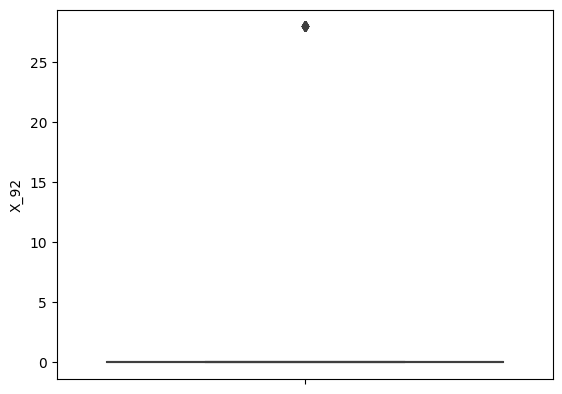

In [163]:
import seaborn as sns
sns.boxplot(y = 'X_92', data = train_df_0)

<AxesSubplot:>

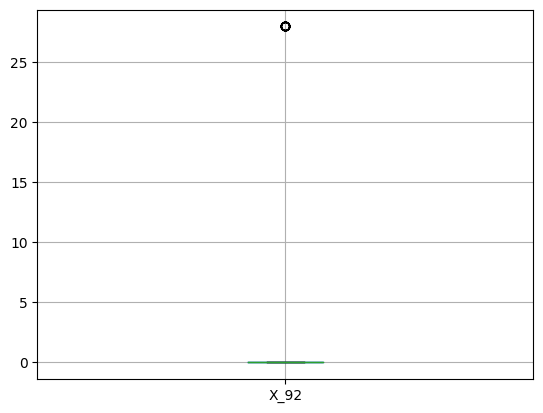

In [166]:
train_df_0.boxplot(column=['X_92'])

In [23]:
##########아웃라이어를 어떻게 제거해줄지 고민하다 끊겼음
value_type_num = train_df.nunique().tolist()
value_type_num

[598,
 3,
 583,
 598,
 6,
 3,
 10,
 16,
 1,
 2,
 13,
 2,
 2,
 1,
 251,
 178,
 169,
 2,
 4,
 8,
 5,
 1,
 67,
 72,
 66,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 5,
 2,
 10,
 12,
 11,
 12,
 11,
 9,
 14,
 12,
 12,
 13,
 12,
 14,
 12,
 13,
 15,
 11,
 14,
 15,
 16,
 13,
 19,
 11,
 19,
 8,
 13,
 13,
 10,
 1,
 1,
 1,
 1,
 1,
 23,
 1,
 1,
 2,
 2,
 2,
 1,
 4,
 1,
 1,
 1,
 2,
 2,
 1,
 13,
 15,
 16,
 1,
 42,
 52,
 33,
 1,
 49,
 54,
 47,
 1,
 46,
 81,
 39,
 1,
 2,
 2,
 2,
 1,
 29,
 31,
 48,
 24,
 23,
 1,
 349,
 175,
 175,
 174,
 174,
 78,
 78,
 42,
 42,
 3,
 2,
 3,
 1,
 67,
 67,
 73,
 99,
 93,
 107,
 2,
 4,
 1,
 108,
 1,
 31,
 32,
 35,
 2,
 3,
 3,
 1,
 2,
 3,
 3,
 1,
 2,
 2,
 3,
 1,
 2,
 2,
 2,
 1,
 2,
 3,
 2,
 1,
 2,
 2,
 3,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 3,
 2,
 1,
 1,
 1,
 27,
 8,
 8,
 8,
 8,
 7,
 7,
 9,
 9,
 9,
 9,
 8,
 8,
 9,
 8,
 8,
 9,
 8,
 8,
 8,
 8,
 7,
 13,
 12,
 12,
 8,
 7,
 10,
 10,
 7,
 13,
 8,
 6,
 8,
 8,
 8,
 7,
 2,
 4,
 3,
 9,
 1,
 37,
 1,
 27,
 27,
 1,